<a href="https://colab.research.google.com/github/tnolivia/Machine_Learning_FGVRI/blob/main/Porto_Seguro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sumário Executivo



* Buscamos analisar os determinantes do acionamento do seguro, de maneira a prever essa ação. 
* Inicialmente, observamos o comportamento das variáveis e notamos o desbalanceamento presente na base de dados. Esse desbalanceamento nos revelou que aproximadamente 97% dos clientes da seguradora não acionaram o seguro, enquanto, apenas 3% o fizeram. Com o intuito de mitigar esse viés, tratamos a base de dados, inclusive balanceando-a sinteticamente. 
* Após aplicarmos diferentes modelos de previsão, como Random Forest e GrandientBoosting, concluímos que essas técnicas não foram suficientes para prever o acionamento de seguro em uma base desbalanceada. 




#Porto Seguro

Grupo: Gustavo Baroni, Nara Gruninger e Olívia Nery.

Segue a discussão do desafio: <a href="{https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/40222}">Porto Seguro</a> 

#Importando dados

In [2]:
# Core
import seaborn as sns
#import pandas as pd
import numpy as np

# Visual
import matplotlib.pyplot as plt
import graphviz
import pprint
import pandas as pd

# Sklearn
from sklearn import tree as sk_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import median_absolute_error, mean_absolute_error, r2_score, max_error, explained_variance_score
from sklearn.model_selection import train_test_split

In [3]:
#import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Inicialmente, vamos entender o comportamento da base de dados utilizada, notamos aqui o comportamento das variáveis. São 59 variáveis, sendo a target nossa variável dependente. Temos diferentes tipos de variáveis: binárias, contínuas, categóricas e ordinais. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
pd.set_option('display.max_columns', None)

#train dataset
train_path = '/content/drive/MyDrive/porto-seguro-safe-driver-prediction/train.csv'
train_df = pd.read_csv(train_path)
df = train_df.copy()
df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


##Distribuição de target

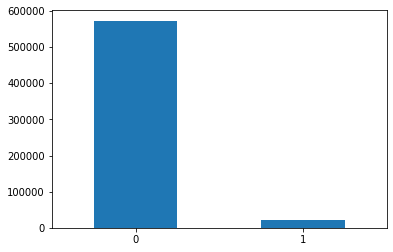

In [ ]:
#distribuição de target
df["target"].value_counts().plot(kind = 'bar')
plt.xticks(rotation = 360);

Como notamos que nossa base de dados apresenta poucas target que acionam o seguro, iremos buscar sua distribuição, de modo a entender a necessidade futura de realizar resampling. 

Também é importante visualizarmos a correlação das variáveis, no entanto, como temos muitas variáveis, não é possível rodar um heatmap com todas pois dificultaria sua compreensão. Desta forma, vamos analisar a correlação das variáveis em relação a target.

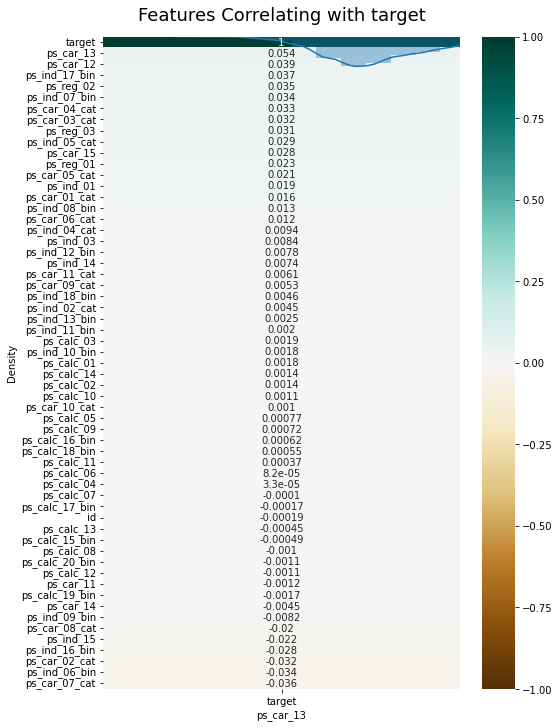

In [ ]:
#Visualizando a correlação das variáveis com target
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['target']].sort_values(by='target', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with target', fontdict={'fontsize':18}, pad=16);



A partir da correlação, vamos visualizar a distribuição da variável (que não seja categórica ou binária) que possui a maior correlação com target.

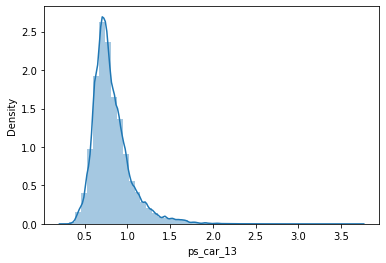

In [ ]:
sns.distplot(df['ps_car_13']);


##Gerando train e test

Vamos dividir a nossa base geral, em treino, validação e teste. Inicialmente, todas as alterações de feature engineering (exceto resampling) serão realizadas em todas. No caso dos modelos, rodaremos primeiro na base de treino e posteriormente em validação e teste. 

In [ ]:
df.columns[2]

'ps_ind_01'

In [ ]:
#dividindo train.csv em train e test
#nesse código dropamos id

labels = df.columns[2:]

X = df[labels]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

In [ ]:
#definindo train e test

train = pd.concat((y_train, X_train), axis = 1)
test = pd.concat((y_test, X_test), axis = 1) #so vamos usar no final

In [ ]:
df.shape

(595212, 59)

In [ ]:
train.shape

(505930, 58)

In [ ]:
test.shape

(89282, 58)

##Gerando treino e validação

Perfeito. Agora temos que dividir a base train em treino e validação

In [ ]:
train.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
311607,0,6,1,5,0,0,0,0,0,1,0,0,0,0,0,8,1,0,0,0.7,0.3,0.653835,11,1,1,0,0,0,1,1,2,1,95,2,0.400000,0.762201,0.334813,3.000000,0.9,0.9,0.6,4,2,8,4,9,2,11,6,2,2,5,0,0,1,0,0,0
366647,0,0,4,9,1,0,0,0,1,0,0,0,0,0,0,8,1,0,0,0.3,0.0,0.792543,7,1,0,0,1,11,1,1,2,1,44,3,0.447214,0.774717,0.339116,3.162278,0.7,0.4,0.1,1,3,4,2,11,1,5,7,3,0,5,0,1,1,0,0,0
471590,0,0,2,2,0,0,1,0,0,0,0,0,0,0,0,11,1,0,0,0.4,0.0,0.923648,11,0,-1,0,-1,10,1,1,2,1,83,2,0.424264,0.949413,0.418569,3.000000,0.5,0.3,0.5,2,2,8,2,10,3,8,3,3,5,5,0,1,1,0,1,0
538416,0,1,1,10,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.9,1.8,1.825685,11,1,1,6,1,14,1,1,2,1,104,0,0.479583,0.832017,0.386005,3.000000,0.5,0.5,0.9,2,0,9,3,10,2,8,2,1,3,7,0,1,1,1,0,1
459085,1,3,1,5,1,4,0,1,0,0,0,0,0,0,0,0,0,0,1,0.9,0.6,1.033501,11,1,-1,0,-1,7,1,1,2,1,96,3,0.446878,0.724640,0.430116,2.645751,0.3,0.0,0.8,3,4,7,5,9,3,8,3,1,1,13,0,0,1,0,0,0


In [ ]:
train.columns[0]

'target'

In [ ]:
#dividindo train
labels = train.columns[1:]

X = train[labels]
y = train['target']

X_treino, X_valid, y_treino, y_valid = train_test_split(X, y, test_size=0.17, random_state=1)

In [ ]:
treino = pd.concat((y_treino, X_treino), axis = 1)
valid = pd.concat((y_valid, X_valid), axis = 1)

In [ ]:
treino.shape

(419921, 58)

In [ ]:
valid.shape

(86009, 58)

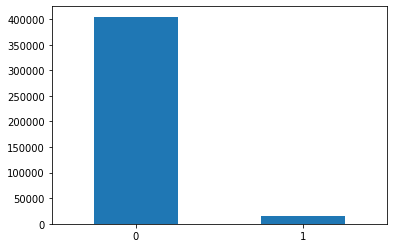

In [ ]:
treino["target"].value_counts().plot(kind = 'bar')
plt.xticks(rotation = 360);

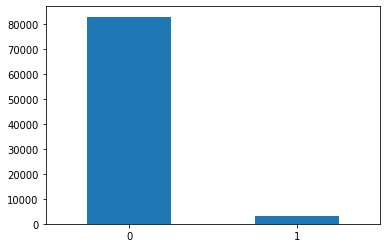

In [ ]:
valid["target"].value_counts().plot(kind = 'bar')
plt.xticks(rotation = 360);

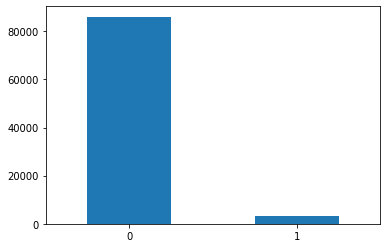

In [ ]:
test["target"].value_counts().plot(kind = 'bar')
plt.xticks(rotation = 360);

Todas as bases apresentam mesmo nível de desbalanceamento e, como a distribuição de target está desbalanceada, iremos realizar um oversampling, isto é, duplicamos as informações de target = 1, até que o balanceamento esteja satisfatório.

#Tratamento

##Resampling com SMOTE

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

labels = treino.columns[1:]

X = treino[labels]
y = treino['target']

X_resampled, y_resampled = SMOTE(random_state=7).fit_resample(X,y)
Counter(y_resampled)

Counter({0: 404674, 1: 404674})

In [ ]:
X_resampled.reset_index(drop=True, inplace=True)
y_resampled.reset_index(drop=True, inplace=True)

Treino resemplada:

In [ ]:
treino = pd.concat((y_resampled, X_resampled), axis = 1)

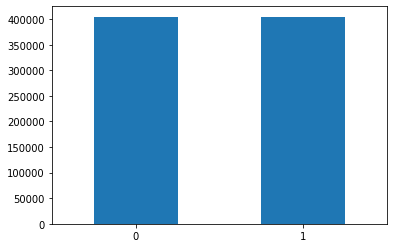

In [ ]:
#distribuição de target
treino["target"].value_counts().plot(kind = 'bar')
plt.xticks(rotation = 360);

Após o resampling, então, a base fica com o balanceamento plotado acima.

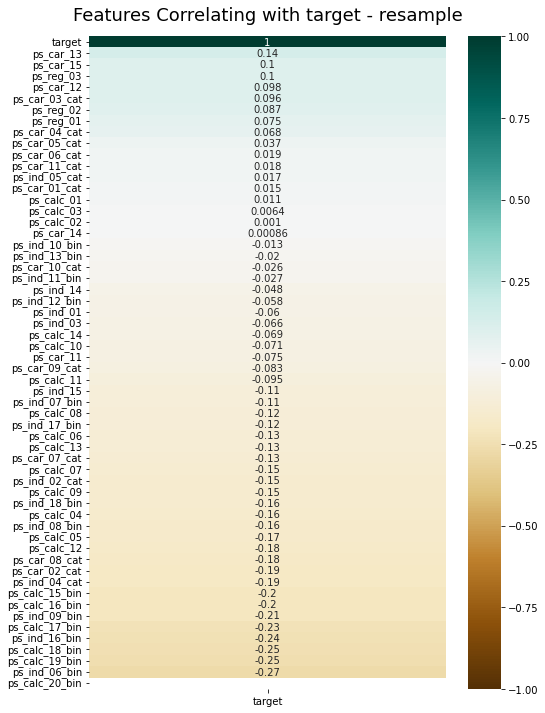

In [ ]:
#Visualizando a correlação das variáveis com target na base resamplada
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(treino.corr()[['target']].sort_values(by='target', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with target - resample', fontdict={'fontsize':18}, pad=16);


##Overview

Agora temos:

*   (1) treino
*   (2) validação (valid)
*   (3) test

Fizemos resample somente para a (1) treino. 

É hora de fazer feature engineering em todas.

#Feature Engineering com NAN



Neste primeiro momento, iremos conduzir a análise substituindo valores -1 por NaN. Ressalta-se que -1 era a forma da base original classificar a falta de informação.

##O que precisamos fazer?

In [ ]:
treino=treino.replace(-1, np.nan)
valid=valid.replace(-1, np.nan)
test=test.replace(-1, np.nan)

treino.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,1,1.0,6,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0.6,0.3,0.646142,6.0,1.0,NaN,0,1.0,11,1.0,1,0.0,1,57,2.0,0.394715,0.586522,0.378550,1.732051,0.3,0.7,0.7,3,3,7,2,10,3,7,4,4,1,6,0,0,1,1,0,0
1,0,0,2.0,3,0.0,0.0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.5,0.2,0.606218,11.0,1.0,NaN,0,NaN,11,1.0,1,2.0,1,19,3.0,0.316228,0.627783,0.388716,2.828427,0.3,0.7,0.3,3,2,8,2,10,2,10,6,2,3,3,0,0,1,0,0,0
2,0,2,1.0,2,1.0,0.0,0,0,0,1,0,0,0,0,0,3,0,0,1,0.9,0.5,0.722409,10.0,1.0,NaN,0,0.0,11,1.0,1,0.0,1,67,2.0,0.374166,0.738101,0.366606,3.464102,0.4,0.3,0.6,2,2,9,3,9,2,6,4,1,0,6,0,0,1,0,0,0
3,0,5,1.0,6,1.0,0.0,0,1,0,0,0,0,0,0,0,8,1,0,0,0.8,1.3,1.283063,10.0,1.0,NaN,0,1.0,0,1.0,0,0.0,1,88,3.0,0.400000,1.019473,0.397492,3.605551,0.3,0.4,0.3,0,3,6,3,8,4,10,5,0,1,5,0,1,1,0,0,0
4,0,0,1.0,5,1.0,6.0,1,0,0,0,0,0,0,0,0,3,0,0,1,0.9,0.4,0.743303,11.0,1.0,NaN,0,NaN,14,1.0,1,2.0,1,68,3.0,0.400000,0.760559,0.407431,2.645751,0.5,0.9,0.6,3,3,7,3,8,2,4,4,4,3,6,0,1,1,0,1,0


Em relação a presença de valores nulos, iremos substituir de acordo com o tipo da variável que possui esses valores. Preenchemos com a média as variáveis que apresentam valores contínuos e com a moda as demais. 

In [ ]:
#vendo as features que precisam ser alteradas
total = treino.isnull().sum().sort_values(ascending=False)

percent = (treino.isnull().sum()/treino.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat(
     [total, percent],
      axis=1,
      keys=['Total', 'Percent'])
      
missing_data.head(18)

,Total,Percent
ps_car_03_cat,472552,0.583868
ps_car_05_cat,283576,0.350376
ps_reg_03,90270,0.111534
ps_car_14,39977,0.049394
ps_car_07_cat,12463,0.015399
ps_ind_05_cat,5744,0.007097
ps_car_09_cat,498,0.000615
ps_ind_02_cat,488,0.000603
ps_car_01_cat,409,0.000505
ps_ind_04_cat,393,0.000486


In [ ]:
treino['ps_car_03_cat'].fillna(treino['ps_car_03_cat'].mode()[0], inplace=True)
treino['ps_car_05_cat'].fillna(treino['ps_car_05_cat'].mode()[0], inplace=True)
treino['ps_car_07_cat'].fillna(treino['ps_car_07_cat'].mode()[0], inplace=True)
treino['ps_car_09_cat'].fillna(treino['ps_car_09_cat'].mode()[0], inplace=True)
treino['ps_car_01_cat'].fillna(treino['ps_car_01_cat'].mode()[0], inplace=True)
treino['ps_car_02_cat'].fillna(treino['ps_car_02_cat'].mode()[0], inplace=True)
treino['ps_ind_05_cat'].fillna(treino['ps_ind_05_cat'].mode()[0], inplace=True)
treino['ps_ind_02_cat'].fillna(treino['ps_ind_02_cat'].mode()[0], inplace=True)
treino['ps_ind_04_cat'].fillna(treino['ps_ind_04_cat'].mode()[0], inplace=True)
treino['ps_reg_03'].fillna(treino['ps_reg_03'].mode()[0], inplace=True)

treino['ps_car_14'].fillna(treino['ps_car_14'].mean(), inplace=True)
treino['ps_car_11'].fillna(treino['ps_car_11'].mean(), inplace=True)
treino['ps_car_12'].fillna(treino['ps_car_12'].mean(), inplace=True)

In [ ]:
total = treino.isnull().sum().sort_values(ascending=False)

percent = (treino.isnull().sum()/treino.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat(
     [total, percent],
      axis=1,
      keys=['Total', 'Percent'])
      
missing_data.head()

,Total,Percent
target,0,0.0
ps_calc_06,0,0.0
ps_car_10_cat,0,0.0
ps_car_11_cat,0,0.0
ps_car_11,0,0.0


In [ ]:
total = valid.isnull().sum().sort_values(ascending=False)

percent = (valid.isnull().sum()/valid.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat(
     [total, percent],
      axis=1,
      keys=['Total', 'Percent'])
      
missing_data.head(18)


,Total,Percent
ps_car_03_cat,59398,0.690602
ps_car_05_cat,38439,0.446918
ps_reg_03,15636,0.181795
ps_car_14,6140,0.071388
ps_car_07_cat,1643,0.019103
ps_ind_05_cat,861,0.010011
ps_car_09_cat,85,0.000988
ps_ind_02_cat,27,0.000314
ps_car_01_cat,17,0.000198
ps_ind_04_cat,11,0.000128


In [ ]:
valid['ps_car_03_cat'].fillna(valid['ps_car_03_cat'].mode()[0], inplace=True)
valid['ps_car_05_cat'].fillna(valid['ps_car_05_cat'].mode()[0], inplace=True)
valid['ps_car_07_cat'].fillna(valid['ps_car_07_cat'].mode()[0], inplace=True)
valid['ps_ind_05_cat'].fillna(valid['ps_ind_05_cat'].mode()[0], inplace=True)
valid['ps_car_09_cat'].fillna(valid['ps_car_09_cat'].mode()[0], inplace=True)
valid['ps_ind_02_cat'].fillna(valid['ps_ind_02_cat'].mode()[0], inplace=True)
valid['ps_car_01_cat'].fillna(valid['ps_car_01_cat'].mode()[0], inplace=True)
valid['ps_ind_04_cat'].fillna(valid['ps_ind_04_cat'].mode()[0], inplace=True)
valid['ps_car_02_cat'].fillna(valid['ps_car_02_cat'].mode()[0], inplace=True)
 
valid['ps_reg_03'].fillna((valid['ps_reg_03'].mean()), inplace=True)
valid['ps_car_14'].fillna((valid['ps_car_14'].mean()), inplace=True)
valid['ps_car_11'].fillna((valid['ps_car_11'].mean()), inplace=True)

In [ ]:
total = valid.isnull().sum().sort_values(ascending=False)

percent = (valid.isnull().sum()/valid.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat(
     [total, percent],
      axis=1,
      keys=['Total', 'Percent'])
      
missing_data.head()

,Total,Percent
target,0,0.0
ps_calc_06,0,0.0
ps_car_10_cat,0,0.0
ps_car_11_cat,0,0.0
ps_car_11,0,0.0


In [ ]:
total = test.isnull().sum().sort_values(ascending=False)

percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat(
     [total, percent],
      axis=1,
      keys=['Total', 'Percent'])
      
missing_data.head(18)


,Total,Percent
ps_car_03_cat,61739,0.691506
ps_car_05_cat,40008,0.448108
ps_reg_03,16186,0.181291
ps_car_14,6421,0.071918
ps_car_07_cat,1711,0.019164
ps_ind_05_cat,832,0.009319
ps_car_09_cat,90,0.001008
ps_ind_02_cat,33,0.000370
ps_car_01_cat,13,0.000146
ps_ind_04_cat,11,0.000123


In [ ]:
test['ps_car_03_cat'].fillna(test['ps_car_03_cat'].mode()[0], inplace=True)
test['ps_car_05_cat'].fillna(test['ps_car_05_cat'].mode()[0], inplace=True)
test['ps_car_07_cat'].fillna(test['ps_car_07_cat'].mode()[0], inplace=True)
test['ps_ind_05_cat'].fillna(test['ps_ind_05_cat'].mode()[0], inplace=True)
test['ps_car_09_cat'].fillna(test['ps_car_09_cat'].mode()[0], inplace=True)
test['ps_ind_02_cat'].fillna(test['ps_ind_02_cat'].mode()[0], inplace=True)
test['ps_car_01_cat'].fillna(test['ps_car_01_cat'].mode()[0], inplace=True)
test['ps_ind_04_cat'].fillna(test['ps_ind_04_cat'].mode()[0], inplace=True)
test['ps_car_02_cat'].fillna(test['ps_car_02_cat'].mode()[0], inplace=True)
 
test['ps_reg_03'].fillna((test['ps_reg_03'].mean()), inplace=True)
test['ps_car_14'].fillna((test['ps_car_14'].mean()), inplace=True)

In [ ]:
total = test.isnull().sum().sort_values(ascending=False)

percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat(
     [total, percent],
      axis=1,
      keys=['Total', 'Percent'])
      
missing_data.head()

,Total,Percent
target,0,0.0
ps_calc_06,0,0.0
ps_car_10_cat,0,0.0
ps_car_11_cat,0,0.0
ps_car_11,0,0.0


##Outlier

Agora, cortaremos os outliers presentes para diminuir o viés na análise.

In [ ]:
#tirando outliers
#treino
n=3

for label, content in treino.items():
   upper_limit = treino[label].mean() + n*treino[label].std () 
   lower_limit = treino[label].mean() - n*treino[label].std ()

treino = treino[(treino[label] < upper_limit) & 
                   (treino[label] > lower_limit)]

#valid
n=3

for label, content in valid.items():
   upper_limit = valid[label].mean() + n*valid[label].std () 
   lower_limit = valid[label].mean() - n*valid[label].std ()

valid = valid[(valid[label] < upper_limit) & 
                   (valid[label] > lower_limit)]

#test
n=3

for label, content in test.items():
   upper_limit = test[label].mean() + n*test[label].std () 
   lower_limit = test[label].mean() - n*test[label].std ()

test = test[(test[label] < upper_limit) & 
                   (test[label] > lower_limit)]


#Modeling

Agora, iremos modelar com Decision Tree, Logistic Regression, Random Forest, Adaboost, GradientBoosting e XGBoosting, compararemos os resultados de cada modelo, visando escolher o modelo que apresenta uma melhor performance. Essa comparação será feita de acordo com a matriz de correlação de cada modelo, que apresenta a acurácia da previsão. Em linhas gerais, esperamos que o False Negative (o modelo previu que a pessoa não acionou o seguro quando na realidade ela havia acionado) seja o menor possível, já que esse erro representaria um custo maior para a seguradora.  

##Decision Tree

###Aplicando DT em treino

In [ ]:
#separando
labels = treino.columns[1:]

X = treino[labels]
y = treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
dt = sk_tree.DecisionTreeClassifier(max_depth = 2)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)


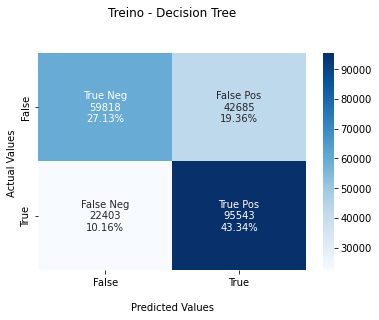

In [ ]:
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Treino - Decision Tree\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado na base treino, tivemos uma taxa de 64.47% de acerto e nosso False Negative é menor do que o False Positive, como desejado.

###Aplicando DT em valid

Lembrando que valid não foi resemplada, vamos testar os parâmetros do modelo em valid:

In [ ]:
#separando
labels = valid.columns[1:]

X = valid[labels]
y = valid['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
dt = sk_tree.DecisionTreeClassifier(max_depth = 2)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

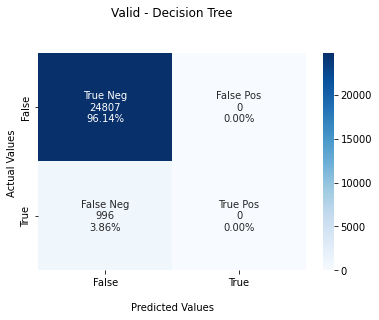

In [ ]:
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Valid - Decision Tree\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Vemos que a decision tree não é suficiente para nos prever casos de sinistro em uma base de dados desbalanceada.




In [ ]:
#Aplicando dt_optimized em valid

#labels = valid.columns[1:]

#X = valid[labels]
#y = valid['target']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#dt_optimized.fit(X_train, y_train)
#y_pred = dt_optimized.predict(X_test)

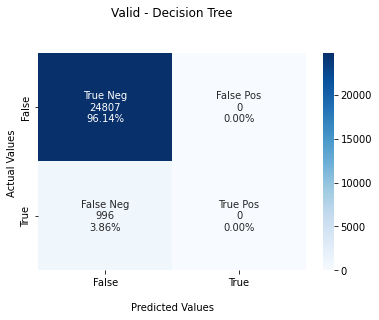

In [ ]:
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Valid - Decision Tree\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

#plt.show()

NB: vale ressaltar que optamos por não incluir optuna de forma geral nos modelos após observado o tempo de execução.

##Logistic Regression

### Aplicando LR em treino

In [ ]:
#separando
labels = treino.columns[1:]

X = treino[labels]
y = treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.linear_model import LogisticRegression
logir = LogisticRegression()
logir.fit(X_train, y_train)
y_pred = logir.predict(X_test)


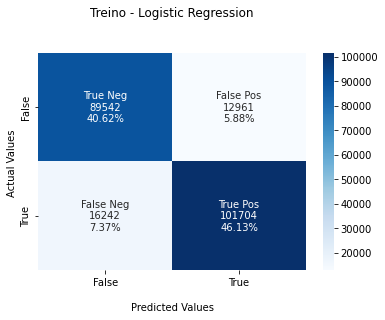

In [ ]:
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Treino - Logistic Regression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Logistic Regression não performou tão bem, em termos de FN.  Com esse modelo aplicado na base de treino, tivemos 86.75% de acerto e nosso False Negative se apresentou maior que o False Positive.

###Aplicando LR em valid

In [ ]:
#separando
labels = valid.columns[1:]

X = valid[labels]
y = valid['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.linear_model import LogisticRegression
logir = LogisticRegression()
logir.fit(X_train, y_train)
y_pred = logir.predict(X_test)


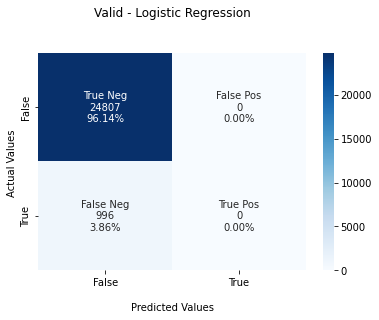

In [ ]:
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Valid - Logistic Regression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Performa de maneira ruim. Com esse modelo aplicado na base de validação, tivemos 96.14% de acerto e nosso False Negative se apresentou maior que o False Positive.

##Random Forest

###Aplicando RF em treino

In [ ]:
#separando
labels = treino.columns[1:]

X = treino[labels]
y = treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators= 100, max_depth = 9)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

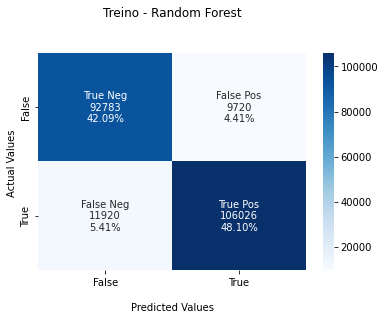

In [ ]:
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Treino - Random Forest\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado na base de treino, tivemos 90.19% de acerto e nosso False Negative se apresentou maior que o False Positive.


###Aplicando RF em valid

In [ ]:
#separando
labels = valid.columns[1:]

X = valid[labels]
y = valid['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators= 100, max_depth = 9)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

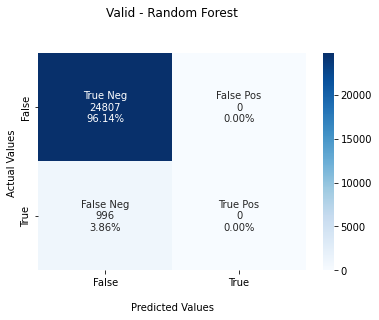

In [ ]:

#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Valid - Random Forest\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado na base de validação, tivemos 96.14% de acerto e nosso False Negative se apresentou maior que o False Positive.

##AdaBoosting

###Aplicanda Ada em treino

In [ ]:
#separando
labels = treino.columns[1:]

X = treino[labels]
y = treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(random_state= 7)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

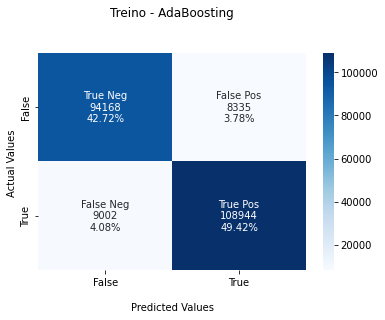

In [ ]:

#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Treino - AdaBoosting\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado na base de treino, tivemos 92.14% de acerto e nosso False Negative se apresentou maior que o False Positive.


###Aplicando Ada em valid

In [ ]:
#separando
labels = valid.columns[1:]

X = valid[labels]
y = valid['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(random_state= 7)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

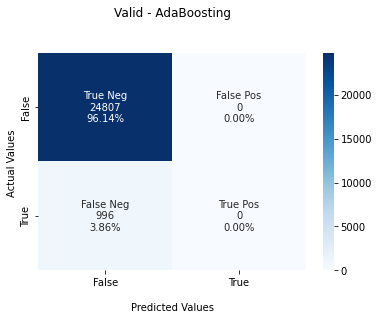

In [ ]:
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Valid - AdaBoosting\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado na base de validação, tivemos 96.14% de acerto e nosso False Negative se apresentou maior que o False Positive. 

##GradientBoosting

In [ ]:
#separando a base que será usada
labels = treino.columns[1:]

X = treino[labels]
y = treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


In [ ]:
#definindo parametros
import optuna
from functools import partial
from sklearn.ensemble import GradientBoostingClassifier

def optimize(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    subsample = trial.suggest_discrete_uniform("subsample", 0.1, 1.0, 0.1)
    max_depth = trial.suggest_int("max_depth", 2, 15)
    max_features = trial.suggest_uniform("max_features", 0.01, 1.0)

    model = GradientBoostingClassifier(
        learning_rate = learning_rate, 
        n_estimators = n_estimators,
        subsample = subsample, 
        max_depth = max_depth,
        max_features = max_features, 
        random_state=0)
    
    gb = GradientBoostingClassifier(
        learning_rate = learning_rate,
        n_estimators = n_estimators,
        subsample = subsample,
        max_depth = max_depth,
        max_features = max_features,
        random_state=0)
    
    gb.fit(X_train, y_train)
    return gb.score(X_test, y_test)
    
#study
#study = optuna.create_study()
#study.optimize(optimize, n_trials = 20)

##esse código rodou por +15h e retornou trial 0 e 1... não se provou viável, então

###Aplicando GB em treino

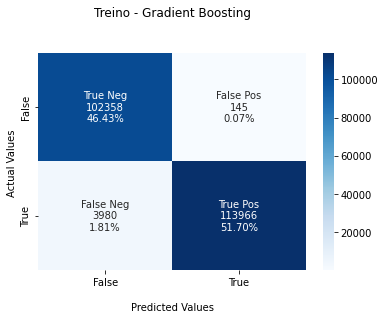

In [ ]:
#separando
labels = treino.columns[1:]

X = treino[labels]
y = treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0,
                                 max_depth=3, random_state=0)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Treino - Gradient Boosting\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado na base de treino, tivemos 98.13% de acerto e nosso False Negative se apresentou maior que o False Positive. 

###Aplicando GB em valid

In [ ]:
#separando
labels = valid.columns[1:]

X = valid[labels]
y = valid['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=3, random_state=0)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

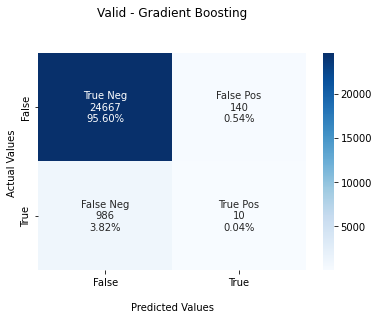

In [ ]:
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Valid - Gradient Boosting\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado na base de validação, tivemos 95.64% de acerto e nosso False Negative se apresentou maior que o False Positive.

##XGBoost

###Aplicando XGBoost em treino

####Reg:Log

In [ ]:
#separando
labels = treino.columns[1:]

X = treino[labels]
y = treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
import xgboost as xgb
xgb = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

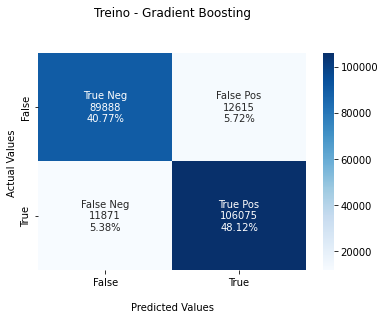

In [ ]:
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Treino - Gradient Boosting\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado em treino, tivemos 88.89% de acerto e o False Negative é menor do que o False Positive.



####Bin:Log

In [ ]:
#modelo

import xgboost as xgb

xgb_c= xgb.XGBClassifier(n_estimators= 100, objective ='binary:logistic', 
                         learning_rate = 0.1, colsample_bytree = 0.3, alpha = 10)

xgb_c.fit(X_train, y_train)
y_pred = xgb_c.predict(X_test)

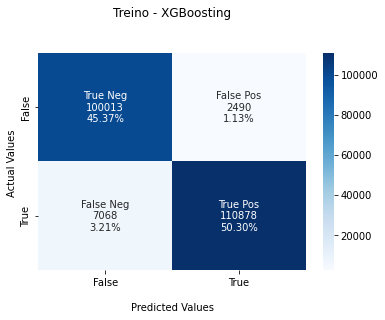

In [ ]:

#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Treino - XGBoosting\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado em treino, tivemos 95.67% de acerto e o False Negative é maior do que o False Positive.

###Aplicando em Valid

In [ ]:
labels = valid.columns[1:]

X = valid[labels]
y = valid['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
import xgboost as xgb

xgb_c= xgb.XGBClassifier(n_estimators= 100, objective ='binary:logistic', 
                         learning_rate = 0.1, colsample_bytree = 0.3, alpha = 10)

xgb_c.fit(X_train, y_train)
y_pred = xgb_c.predict(X_test)

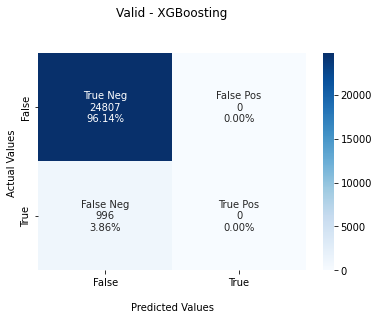

In [ ]:
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Valid - XGBoosting\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Esse modelo continua performando mal e não nos é útil para a generalização da previsão de acionamenteo de seguros.

##Testando modelos com features selecionadas

###Feature importance

In [ ]:
#separando
labels = treino.columns[1:]

X = treino[labels]
y = treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=9, 
                            min_samples_leaf=4, max_features=0.2, n_jobs=-1, 
                            random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
features = X_train.columns.values
import plotly.graph_objs as go
import plotly.offline as py


x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

#features importantes = feature importance> 0.05
#ps_ind_06_bin, ps_reg_03, ps_ind_09_bin, ps_calc_18_bin, ps_calc_19_bin, ps_reg_02, ps_ind_08_bin, ps_reg_01

###Random forest





####RF em treino

In [ ]:
#features importantes = feature importance> 0.05
#ps_ind_06_bin, ps_reg_03, ps_ind_09_bin, ps_calc_18_bin, ps_calc_19_bin, ps_reg_02, ps_ind_08_bin, ps_reg_01

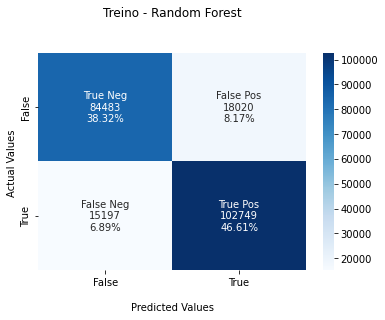

In [ ]:
labels = ["ps_ind_06_bin", "ps_reg_03",
                "ps_ind_09_bin", "ps_calc_18_bin", "ps_calc_19_bin", "ps_reg_02", "ps_ind_08_bin", "ps_reg_01"]

X = treino[labels]
y = treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators= 100, max_depth = 9)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Treino - Random Forest\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Como esse modelo aplicado em treino, tivemos 84.93% de acerto e False Negative é menor do que False Positive.

####RF em valid

In [ ]:
#separando

X = valid[labels]
y = valid['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators= 100, max_depth = 9)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

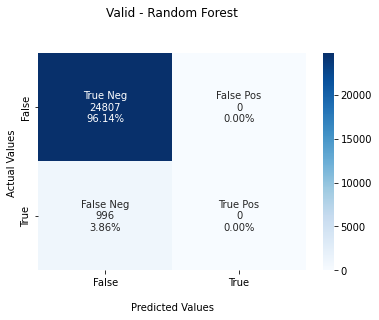

In [ ]:
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Valid - Random Forest\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Modelo insuficiente para nossa previsão.

###Gradient Boosting

####GB em treino

In [ ]:
#separando
labels = ["ps_ind_06_bin", "ps_reg_03",
                "ps_ind_09_bin", "ps_calc_18_bin", "ps_calc_19_bin", "ps_reg_02", "ps_ind_08_bin", "ps_reg_01"]

X = treino[labels]
y = treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0,
                                 max_depth=3, random_state=0)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [ ]:
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Treino - Gradient Boosting\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado na base de treino, tivemos 98.13% de acerto e nosso False Negative se apresentou maior que o False Positive. 

####GB em valid

In [ ]:
X = valid[labels]
y = valid['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=3, random_state=0)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

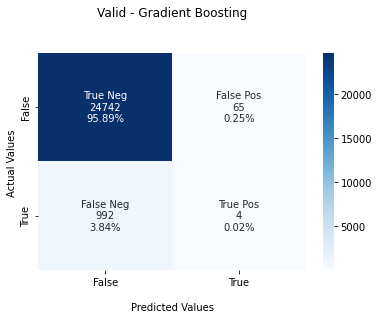

In [ ]:
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Valid - Gradient Boosting\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado na base de valid, tivemos 96.91% de acerto e nosso False Negative é maior do que o False Positive.

##Feature Engineering com -1

Agora, repetiremos os modelos com a base não alterada, isto é, com a presença de -1. Queremos analisar se há alteração dos resultados supracitados. 

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

#train dataset
train_path = '/content/drive/MyDrive/porto-seguro-safe-driver-prediction/train.csv'
train_df = pd.read_csv(train_path)
df = train_df.copy()

labels = df.columns[2:]

X = df[labels]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

#definindo train e test

train = pd.concat((y_train, X_train), axis = 1)
test = pd.concat((y_test, X_test), axis = 1) #so vamos usar no final

#dividindo train
labels = train.columns[1:]

X = train[labels]
y = train['target']

X_treino, X_valid, y_treino, y_valid = train_test_split(X, y, test_size=0.17, random_state=1)

treino = pd.concat((y_treino, X_treino), axis = 1)
valid = pd.concat((y_valid, X_valid), axis = 1)

from collections import Counter
from imblearn.over_sampling import SMOTE

labels = treino.columns[1:]

X = treino[labels]
y = treino['target']

X_resampled, y_resampled = SMOTE(random_state=7).fit_resample(X,y)
Counter(y_resampled)

X_resampled.reset_index(drop=True, inplace=True)
y_resampled.reset_index(drop=True, inplace=True)
treino = pd.concat((y_resampled, X_resampled), axis = 1)

#tirando outliers
#treino
n=3

for label, content in treino.items():
   upper_limit = treino[label].mean() + n*treino[label].std () 
   lower_limit = treino[label].mean() - n*treino[label].std ()

treino = treino[(treino[label] < upper_limit) & 
                   (treino[label] > lower_limit)]

#valid
n=3

for label, content in valid.items():
   upper_limit = valid[label].mean() + n*valid[label].std () 
   lower_limit = valid[label].mean() - n*valid[label].std ()

valid = valid[(valid[label] < upper_limit) & 
                   (valid[label] > lower_limit)]

#test
n=3

for label, content in test.items():
   upper_limit = test[label].mean() + n*test[label].std () 
   lower_limit = test[label].mean() - n*test[label].std ()

test = test[(test[label] < upper_limit) & 
                   (test[label] > lower_limit)]

Mounted at /content/drive/


##DT

###DT em treino

In [ ]:
#separando
labels = treino.columns[1:]

X = treino[labels]
y = treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
dt = sk_tree.DecisionTreeClassifier(max_depth = 2)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

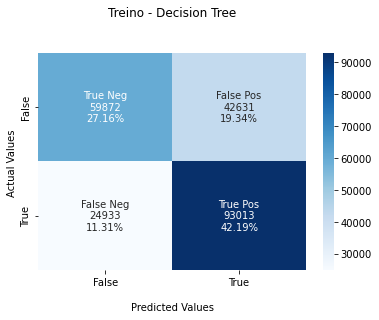

In [ ]:
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Treino - Decision Tree\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado na base treino, tivemos uma taxa de 69.35% de acerto e nosso False Negative é menor do que o False Positive, como desejado.

###DT em valid

In [ ]:
#separando
labels = valid.columns[1:]

X = valid[labels]
y = valid['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
dt = sk_tree.DecisionTreeClassifier(max_depth = 2)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)



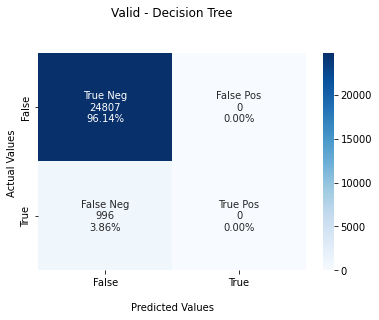

In [ ]:
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Valid - Decision Tree\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Nosso modelo não foi útil quando aplicado em valid.

##LogRegression

###LR em treino

In [ ]:
#separando
labels = treino.columns[1:]

X = treino[labels]
y = treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.linear_model import LogisticRegression
logir = LogisticRegression()
logir.fit(X_train, y_train)
y_pred = logir.predict(X_test)

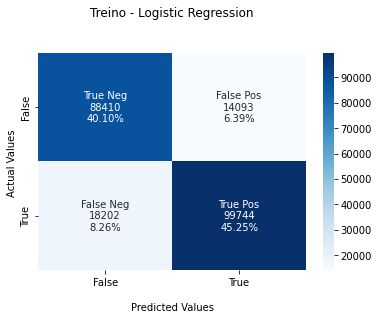

In [ ]:
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Treino - Logistic Regression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado na base de treino, tivemos 85.35% de acerto e nosso False Negative se apresentou maior que o False Positive.

###LR em valid

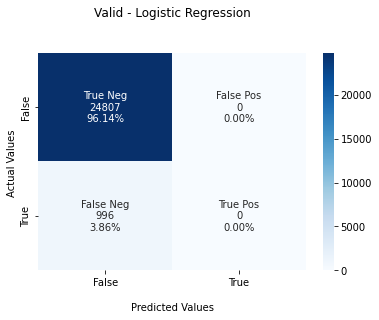

In [ ]:
#separando
labels = valid.columns[1:]

X = valid[labels]
y = valid['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.linear_model import LogisticRegression
logir = LogisticRegression()
logir.fit(X_train, y_train)
y_pred = logir.predict(X_test)

#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Valid - Logistic Regression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado na base de validação, tivemos 96.14% de acerto e nosso False Negative se apresentou maior que o False Positive.

##RF

###RF em treino

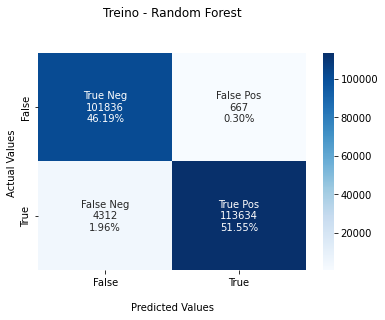

In [ ]:
#separando
labels = treino.columns[1:]

X = treino[labels]
y = treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators= 100, max_depth = 9)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
#Teste olivia
#separando
labels = treino.columns[1:]

X = treino[labels]
y = treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators= 400, max_depth = 40, min_samples_leaf = 4)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Treino - Random Forest\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()


Com esse modelo aplicado na base de treino, tivemos 97.74% de acerto e nosso False Negative se apresentou maior que o False Positive. 

###RF em valid

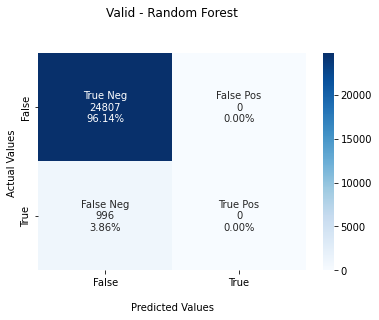

In [ ]:
#separando
labels = valid.columns[1:]

X = valid[labels]
y = valid['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators= 100, max_depth = 9)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Valid - Random Forest\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado na base de validação, tivemos 96.14% de acerto e nosso False Negative se apresentou maior que o False Positive.

##Ada

###Ada em treino

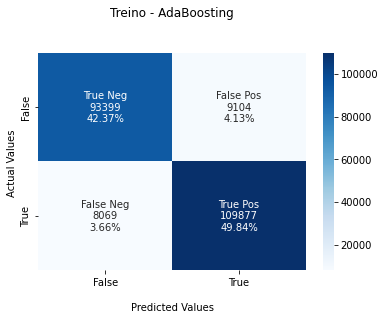

In [ ]:
#separando
labels = treino.columns[1:]

X = treino[labels]
y = treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(random_state= 7)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Treino - AdaBoosting\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado na base de treino, tivemos 92.21% de acerto e nosso False Negative se apresentou menor que o False Positive.

###Ada em valid

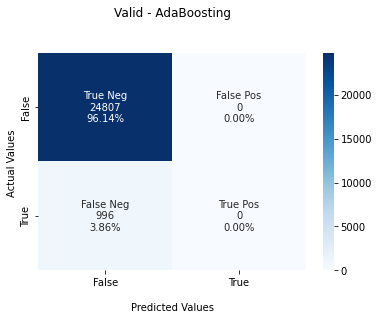

In [ ]:
#separando
labels = valid.columns[1:]

X = valid[labels]
y = valid['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(random_state= 7)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Valid - AdaBoosting\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado na base de validação, tivemos 96.14% de acerto e nosso False Negative se apresentou menor que o False Positive.

##Gradient

###GB em treino

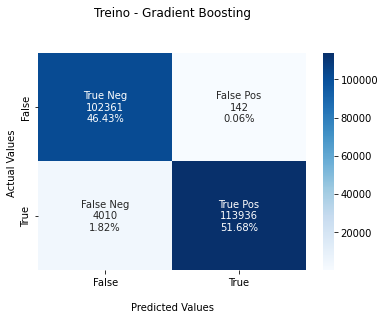

In [ ]:
#separando
labels = treino.columns[1:]

X = treino[labels]
y = treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0,
                                 max_depth=3, random_state=0)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Treino - Gradient Boosting\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado na base de treino, tivemos 98.11% de acerto e nosso False Negative se apresentou maior que o False Positive.

###GB em valid

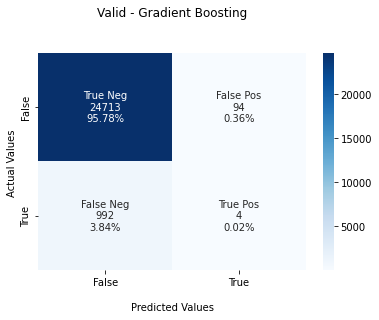

In [ ]:
#separando
labels = valid.columns[1:]

X = valid[labels]
y = valid['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0,
                                 max_depth=3, random_state=0)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Valid - Gradient Boosting\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado na base de valid, tivemos 95.78% de acerto e nosso False Negative se apresentou maior que o False Positive.

##XGB

###XGB em treino

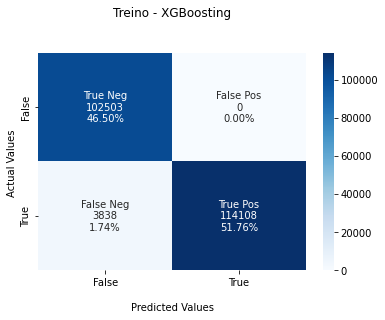

In [ ]:
labels = treino.columns[1:]

X = treino[labels]
y = treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modelo

import xgboost as xgb

xgb_c= xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.3,
                max_depth = 3, alpha = 10, n_estimators = 100, objective ='binary:hinge')


xgb_c.fit(X_train, y_train)
y_pred = xgb_c.predict(X_test)
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Treino - XGBoosting\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado em treino, tivemos 98.26% de acerto e nosso False Negative foi do que o False Positive.

###XGB em valid

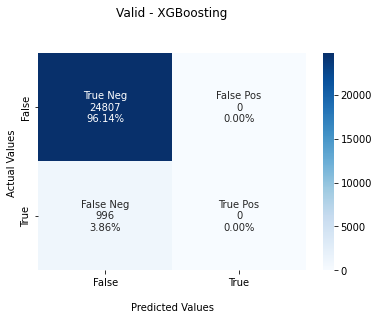

In [ ]:
labels = valid.columns[1:]

X = valid[labels]
y = valid['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modelo

import xgboost as xgb

xgb_c= xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.3,
                max_depth = 3, alpha = 10, n_estimators = 100, objective ='binary:hinge')

xgb_c.fit(X_train, y_train)
y_pred = xgb_c.predict(X_test)
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Valid - XGBoosting\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

Com esse modelo aplicado em validação, tivemos 96.14% de acerto e nosso False Negative foi do que o False Positive.

Com esse modelo aplicado na base de teste, tivemos 95.88% de acerto e nosso False Negative se apresentou maior que o False Positive. No entanto, diferente dos outros modelos, ele fugiu ligeiramente do viés de desbalanceamento. 

#Aplicando em teste

Como o Gradientboosting apresentou uma melhor performance frente aos outros modelos, iremos rodá-lo em teste. 

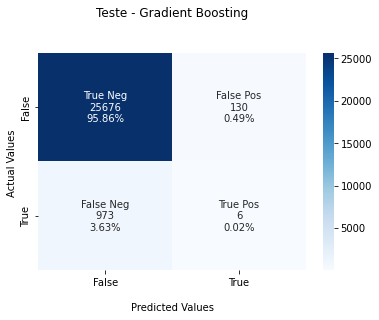

In [6]:
#separando
labels = test.columns[1:]

X = test[labels]
y = test['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#modeling
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0,
                                 max_depth=3, random_state=0)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
#Acurácia
from sklearn.metrics import confusion_matrix

#Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Teste - Gradient Boosting\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

plt.show()

#Resultados

De maneira geral, os modelos rodados com a base original (presença de -1) não apresentaram diferenças significativas entre seus resultados rodados com a base alterada. No caso da aplicação dos modelos na base de validação, eles não apresentaram diferenças significativas entre si e os resultados seguiram insatisfatórios, isto é, a proporção encontrada na maioria dos testes (97% e 3%) se assemelha a distribuição da target. Logo, como temos poucos target = 1, o modelo prefere prever que a maior parte das pessoas não acionam o seguro. Nossa conclusão, portanto, é que, apesar de treinar diferentes modelos em uma base balanceada, quando aplicado na validação, o modelo minimiza o erro e opta por seguir o alto viés dos dados. 


#Conclusão

Visto que os modelos não foram o suficientes para predizer se o indivíduo acionará o seguro ou não, é necessário desenvolver os modelos. Alguns caminhos possíveis seriam a avaliação das melhores variáveis que poderiam ser usadas no modelo, com base no gráfico de correlação. Ademais, visto que, inicialmente, a base era desbalanceada, para aprimorar nossa previsão, pode-se explorar outros métodos de resampling como o undersampling ou oversampling por randomização ou a técnica de tomek links, por exemplo. Por último, seria interessante, também, lidar diferentemente com variáveis categóricas, binárias e contínuas. Devido ao grande número de variáveis e a falta de observação sobre elas, tivemos dificuldades em tratá-las, no entanto, se dividirmos elas, poderíamos aplicar técnicas como a de one hot encoding para variáveis categóricas e a normalização da distribuição de variáveis contínuas. Dito isso, ressaltamos que não foi possível dar continuidade nessas técnicas alternativas e complementares por limitação de recursos.